In [1]:
import pandas as pd
import numpy as np
import datetime as dt
from datetime import date, timedelta
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
import tensorflow as tf
import vectorbt as vbt
import pandas_ta as ta
import requests
import logging
import sys
import shap
import random
from datasets import load_dataset
from gunsan_strength.core import get_gunsan_strength
from gunsan_strength.plots import plot_gunsan_strength
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
from arch import arch_model
from prophet import Prophet
from sklearn.ensemble import RandomForestRegressor
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import warnings
import os
from tensorflow.keras import backend as K
from tensorflow.keras import layers
from tensorflow.keras import models
from dotenv import load_dotenv
import optuna
from optuna.integration import TFKerasPruningCallback
import warnings
warnings.filterwarnings('ignore')

2025-06-08 11:25:40.207441: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749378341.036994    6219 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749378341.189044    6219 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1749378342.549704    6219 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1749378342.549755    6219 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1749378342.549759    6219 computation_placer.cc:177] computation placer alr

In [2]:
%pwd

'/home/santoshkumarguntupalli/data_science/Natural_Gas_Price_Forecast/research'

In [3]:
os.chdir('/home/santoshkumarguntupalli/data_science/Natural_Gas_Price_Forecast')
%pwd

'/home/santoshkumarguntupalli/data_science/Natural_Gas_Price_Forecast'

In [4]:
# Configure Logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

In [5]:
# Set API key as environment variable
load_dotenv(dotenv_path=".env")
EIA_API_KEY = os.getenv('EIA_API_KEY')

In [6]:
# Function to Download Data with Error Handling
def download_data(ticker, start_date, end_date):
    try:
        data = yf.download(ticker, start=start_date, end=end_date, multi_level_index=False)
        data.reset_index(inplace=True)
        return data
    except Exception as e:
        logger.error(f"Failed to download data: {str(e)}")
        sys.exit(1)


In [7]:
# Define Constants
TICKER = 'NG=F'
START_DATE = '2009-01-01'
END_DATE = date.today().strftime("%Y-%m-%d")
TIME_STEP = 60
FORECAST_HORIZON = 30

In [8]:
# Download Data
data = download_data(TICKER, START_DATE, END_DATE)

logger.info(f"Downloaded data from {START_DATE} to {END_DATE}")

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed
INFO:__main__:Downloaded data from 2009-01-01 to 2025-06-08


In [9]:
data

,Date,Close,High,Low,Open,Volume
0,2009-01-02,5.971,6.088,5.503,5.550,41110
1,2009-01-05,6.072,6.142,5.825,5.930,42385
2,2009-01-06,5.983,6.240,5.865,6.083,57506
3,2009-01-07,5.872,6.070,5.784,5.985,48756
4,2009-01-08,5.583,6.004,5.550,5.675,74717
...,...,...,...,...,...,...
4128,2025-06-02,3.694,3.750,3.501,3.501,199977
4129,2025-06-03,3.722,3.764,3.630,3.748,139410
4130,2025-06-04,3.716,3.740,3.661,3.729,126093
4131,2025-06-05,3.677,3.791,3.620,3.703,208764


In [10]:
# Compute GunSan Strength Index
def compute_gunsan_strength(data, signal_window=50):
    try:
        result = get_gunsan_strength(data, signal_window=signal_window)
        return result
    except Exception as e:
        logger.error(f"Failed to compute GunSan Strength: {str(e)}")
        return None
result = compute_gunsan_strength(data)
if result is None:
    sys.exit(1)

In [11]:
# Plot the result
plot_gunsan_strength(result)

In [12]:
result.head()

,Date,Close,Technical_Strength,Technical_Strength_Signal
0,2009-01-02,5.971,NaN,NaN
1,2009-01-05,6.072,NaN,NaN
2,2009-01-06,5.983,NaN,NaN
3,2009-01-07,5.872,NaN,NaN
4,2009-01-08,5.583,NaN,NaN


In [13]:
# Load Utility Gas Heating Degree Days CONUS Data
def load_utility_gas_conus_data():
    dfs = []
    start_date = pd.to_datetime("2010-01-01")
    current_date = pd.to_datetime("today")
    for year in range(start_date.year, current_date.year + 1):
        file_url = f"https://ftp.cpc.ncep.noaa.gov/htdocs/degree_days/weighted/daily_data/{year}/UtilityGas.Heating.txt"
        try:
            response = requests.get(file_url, timeout=10)
            if response.status_code == 200:
                content = response.text
                lines = content.split('\n')
                headers = lines[3].split('|')
                date_headers = [h for h in headers if h.startswith('20')]
                data_lines = lines[4:]
                for line in data_lines:
                    if not line.strip():
                        continue
                    if line.startswith("CONUS|"):
                        parts = line.strip().split('|')
                        hdds = parts[1:]
                        if len(hdds) != len(date_headers):
                            logger.warning(f"Mismatch in date and HDD counts for {year}")
                            continue
                        df = pd.DataFrame({
                            'Date': pd.to_datetime(date_headers, format='%Y%m%d'),
                            'Hdd': list(map(int, hdds)),
                            'year': year
                        })
                        df = df[df['Date'] >= start_date]
                        df.set_index('Date', inplace=True)
                        dfs.append(df)
                        logger.info(f"Loaded CONUS data for {year}")
                        break
        except Exception as e:
            logger.error(f"Failed to load {year}: {str(e)}")
    if dfs:
        return pd.concat(dfs)
    else:
        return None


In [14]:
hdd_df = load_utility_gas_conus_data()
if hdd_df is not None:
    logger.info("Filtered CONUS HDD data loaded successfully!")
else:
    logger.error("No CONUS data was loaded.")
    sys.exit(1)

INFO:__main__:Loaded CONUS data for 2010
INFO:__main__:Loaded CONUS data for 2011
INFO:__main__:Loaded CONUS data for 2012
INFO:__main__:Loaded CONUS data for 2013
INFO:__main__:Loaded CONUS data for 2014
INFO:__main__:Loaded CONUS data for 2015
INFO:__main__:Loaded CONUS data for 2016
INFO:__main__:Loaded CONUS data for 2017
INFO:__main__:Loaded CONUS data for 2018
INFO:__main__:Loaded CONUS data for 2019
INFO:__main__:Loaded CONUS data for 2020
INFO:__main__:Loaded CONUS data for 2021
INFO:__main__:Loaded CONUS data for 2022
INFO:__main__:Loaded CONUS data for 2023
INFO:__main__:Loaded CONUS data for 2024
INFO:__main__:Loaded CONUS data for 2025
INFO:__main__:Filtered CONUS HDD data loaded successfully!


In [15]:
# Fetch Inventory Data
def fetch_inventory_bcf_eia(start_dt='2010-01-01', end_dt=None, api_key=None):
    if end_dt is None:
        end_dt = date.today().strftime("%Y-%m-%d")
    if api_key is None:
        logger.error("Please provide your EIA API key.")
        sys.exit(1)
    url = (
        "https://api.eia.gov/v2/natural-gas/stor/wkly/data/"
        f"?api_key={api_key}"
        "&frequency=weekly"
        "&data[0]=value"
        "&facets[series][]=NW2_EPG0_SWO_R48_BCF"
        f"&start={start_dt}"
        f"&end={end_dt}"
        "&sort[0][column]=period"
        "&sort[0][direction]=asc"
        "&offset=0"
        "&length=5000"
    )
    try:
        response = requests.get(url, timeout=10)
        response.raise_for_status()
        data_json = response.json()
        if 'response' in data_json and 'data' in data_json['response']:
            records = data_json['response']['data']
            df_storage = pd.DataFrame(records)
            df_storage['Date'] = pd.to_datetime(df_storage['period'])
            df_storage = df_storage.rename(columns={'value': 'Inventory_Bcf'})
            df_storage['Inventory_Bcf'] = df_storage['Inventory_Bcf'].astype(int)
            df_storage = df_storage[['Date', 'Inventory_Bcf']].sort_values('Date')
            df_storage = df_storage.set_index('Date').resample('D').ffill()
            return df_storage
        else:
            logger.error("API Error:", data_json.get('error', 'Unknown issue'))
            return None
    except Exception as e:
        logger.error(f"Failed to fetch inventory data: {str(e)}")
        return None

In [16]:
df_inventory = fetch_inventory_bcf_eia(api_key=EIA_API_KEY, end_dt=END_DATE)
if df_inventory is not None:
    logger.info("Inventory data loaded successfully!")
else:
    logger.error("Failed to load inventory data.")
    sys.exit(1)

INFO:__main__:Inventory data loaded successfully!


In [17]:
result

,Date,Close,Technical_Strength,Technical_Strength_Signal
0,2009-01-02,5.971,NaN,NaN
1,2009-01-05,6.072,NaN,NaN
2,2009-01-06,5.983,NaN,NaN
3,2009-01-07,5.872,NaN,NaN
4,2009-01-08,5.583,NaN,NaN
...,...,...,...,...
4128,2025-06-02,3.694,0.129467,0.054347
4129,2025-06-03,3.722,0.122031,0.050346
4130,2025-06-04,3.716,0.152118,0.048279
4131,2025-06-05,3.677,0.109220,0.045966


In [18]:
result["Return"]=result['Close'].pct_change()
result['Hist_Vol'] = result['Return'].rolling(window=252).std() * np.sqrt(252)
result["Volume"]=data["Volume"]

In [19]:
# Merge and Prepare Data
result = pd.merge(result, hdd_df["Hdd"], on='Date', how='left')
result = pd.merge(result, df_inventory, on='Date', how='left')
result = result[result['Date']>= '2010-01-01']

In [20]:
print(result.isnull().sum())

Date                         0
Close                        0
Technical_Strength           0
Technical_Strength_Signal    0
Return                       0
Hist_Vol                     0
Volume                       0
Hdd                          0
Inventory_Bcf                5
dtype: int64


In [21]:
# Handle Missing Values
result['Inventory_Bcf'] = result['Inventory_Bcf'].interpolate(method='linear', limit_direction='both')
result['Hdd'] = result['Hdd'].interpolate(method='linear', limit_direction='both')

In [22]:
result.head()

,Date,Close,Technical_Strength,Technical_Strength_Signal,Return,Hist_Vol,Volume,Hdd,Inventory_Bcf
252,2010-01-04,5.884,0.520376,0.276366,0.055994,0.780515,78858,39.0,3117.0
253,2010-01-05,5.637,0.425686,0.278883,-0.041978,0.781538,99492,38.0,3117.0
254,2010-01-06,6.009,0.610025,0.289526,0.065993,0.784088,140611,36.0,3117.0
255,2010-01-07,5.806,0.618388,0.301580,-0.033783,0.784620,135113,36.0,3117.0
256,2010-01-08,5.749,0.504525,0.311377,-0.009817,0.783070,101153,39.0,2850.0


In [23]:
# Feature Engineering
def add_features(df):
    df['Inventory_Bcf_lag3'] = df['Inventory_Bcf'].shift(3)
    df['Hdd_ma30'] = df['Hdd'].rolling(window=30).mean()
    df['Inventory_ma30'] = df['Inventory_Bcf'].rolling(window=30).mean()
    df['Hdd_cumsum'] = df['Hdd'].cumsum()
    df['Inventory_cumsum'] = df['Inventory_Bcf'].cumsum()
    df['Volume_ma30'] = df['Volume'].rolling(window=30).mean()
    df['Volume_cumsum'] = df['Volume'].cumsum()
    return df

In [24]:
result = add_features(result)
result = result.dropna()

In [25]:
result.isnull().sum()

Date                         0
Close                        0
Technical_Strength           0
Technical_Strength_Signal    0
Return                       0
Hist_Vol                     0
Volume                       0
Hdd                          0
Inventory_Bcf                0
Inventory_Bcf_lag3           0
Hdd_ma30                     0
Inventory_ma30               0
Hdd_cumsum                   0
Inventory_cumsum             0
Volume_ma30                  0
Volume_cumsum                0
dtype: int64

In [26]:
import plotly.graph_objects as go

fig = go.Figure()

# Inventory_Bcf (left axis)
fig.add_trace(go.Scatter(
    x=result.index,
    y=result['Inventory_ma30'],
    name='Inventory_Bcf',
    yaxis='y',
    line=dict(color='#1ABC9C')
))

# HDD (right axis)
fig.add_trace(go.Scatter(
    x=result.index,
    y=result['Hdd_ma30'],
    name='HDD',
    yaxis='y2',
    line=dict(color='#F39C12')
))

# Close Price (far-right axis)
fig.add_trace(go.Scatter(
    x=result.index,
    y=result['Close'],
    name='Close Price',
    yaxis='y3',
    line=dict(color='#3498DB')
))

# 🔧 Layout with 3 y-axes
fig.update_layout(
    title='Inventory, HDD, and Natural Gas Price (Multi-Axis)',
    xaxis=dict(
        domain=[0.1, 0.85]
    ),
    yaxis=dict(  # y (left)
        title='Inventory_Bcf',
        titlefont=dict(color='#1ABC9C'),
        tickfont=dict(color='#1ABC9C'),
        anchor='x',
        side='left',
        position=0.0
    ),
    yaxis2=dict(  # y2 (right)
        title='HDD',
        titlefont=dict(color='#F39C12'),
        tickfont=dict(color='#F39C12'),
        anchor='x',
        overlaying='y',
        side='right',
        position=0.85
    ),
    yaxis3=dict(  # y3 (far-right)
        title='Close Price',
        titlefont=dict(color='#3498DB'),
        tickfont=dict(color='#3498DB'),
        anchor='free',
        overlaying='y',
        side='right',
        position=1.0
    ),
    legend=dict(x=0.5, y=1.15, orientation='h'),
    margin=dict(l=60, r=80, t=80, b=40),
    width=1100,
    height=500
)

fig.show()


In [27]:
# Define float32/float64 types
feature_dtypes = {
    'Close': 'float32',
    'Technical_Strength': 'float32',
    'Technical_Strength_Signal': 'float32',
    'Hist_Vol': 'float32',
    'Inventory_Bcf': 'float32',
    'Inventory_Bcf_lag3': 'float32',
    'Hdd_ma30': 'float32',
    'Inventory_ma30': 'float32',
    'Hdd_cumsum': 'float32',
    'Inventory_cumsum': 'float64',  
    'Volume_ma30': 'float32',
    'Volume_cumsum': 'float64'      
}


In [28]:
# Split Data
def split_data(data, test_size=0.25, random_state=42):
    try:
        df_train, df_test = train_test_split(data, test_size=test_size, shuffle=False, random_state=random_state)

        return df_train, df_test
    except Exception as e:
        logger.error(f"Failed to split data: {str(e)}")
        return None
    
df_model = result.drop(columns=['Date', 'Return', 'Volume', 'Hdd'])
df_model = df_model.round(2).astype(feature_dtypes)

df_train, df_test = split_data(df_model)
if df_train is None:
    sys.exit(1)

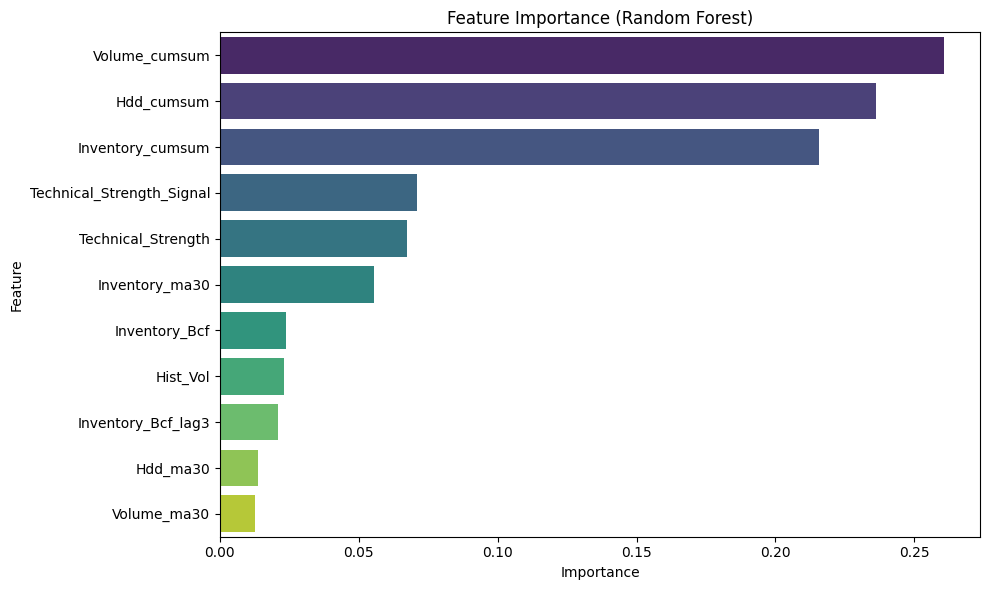

In [29]:
importances_model = RandomForestRegressor(n_estimators=100, random_state=42)
importances_model.fit(df_train.drop(columns=['Close']), df_train['Close'])

# Get feature importances
importances = importances_model.feature_importances_
feature_names = df_train.drop(columns=['Close']).columns

# Create a nice plot
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Plot
plt.figure(figsize=(10,6))
sns.barplot(data=importance_df, x='Importance', y='Feature', palette='viridis')
plt.title("Feature Importance (Random Forest)")
plt.tight_layout()
plt.show()

In [30]:
importance_df

,Feature,Importance
10,Volume_cumsum,0.260606
7,Hdd_cumsum,0.236356
8,Inventory_cumsum,0.215524
1,Technical_Strength_Signal,0.071092
0,Technical_Strength,0.067343
6,Inventory_ma30,0.055323
3,Inventory_Bcf,0.023734
2,Hist_Vol,0.022918
4,Inventory_Bcf_lag3,0.020825
5,Hdd_ma30,0.013720


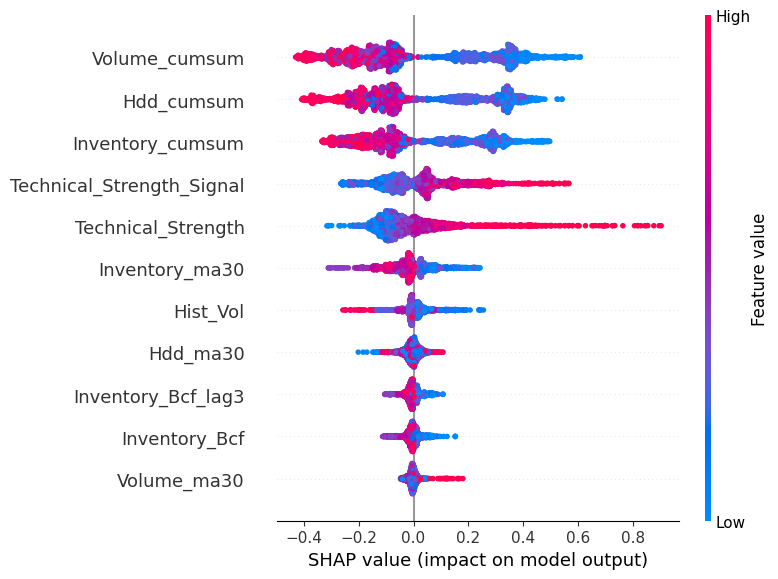

In [31]:
explainer = shap.Explainer(importances_model)
shap_values = explainer(df_train.drop(columns=['Close']))

shap.summary_plot(shap_values, df_train.drop(columns=['Close']))

In [32]:
correlations = result.corr()
correlations['Close'].sort_values(ascending=False)


Close                        1.000000
Technical_Strength_Signal    0.664047
Technical_Strength           0.556481
Hist_Vol                     0.340150
Return                       0.055864
Hdd                         -0.013993
Hdd_ma30                    -0.047662
Volume_cumsum               -0.061025
Date                        -0.072077
Inventory_cumsum            -0.072710
Hdd_cumsum                  -0.076321
Inventory_Bcf               -0.132197
Inventory_Bcf_lag3          -0.135070
Inventory_ma30              -0.157322
Volume                      -0.163913
Volume_ma30                 -0.340499
Name: Close, dtype: float64

<Axes: >

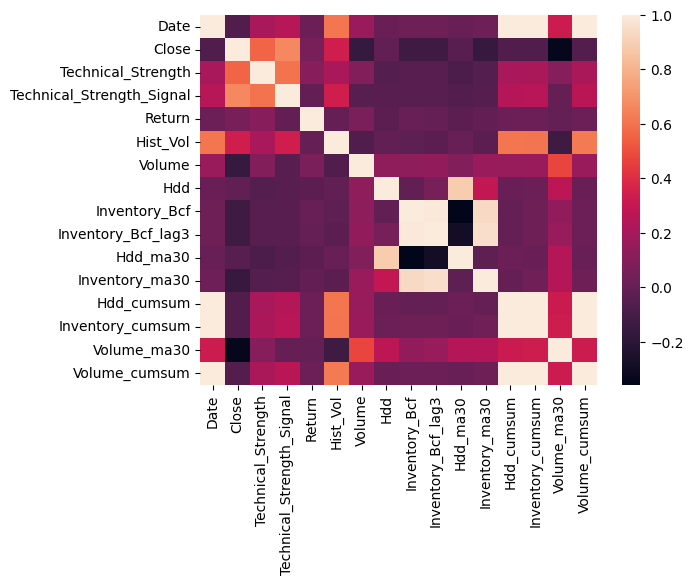

In [33]:
sns.heatmap(correlations)

In [34]:
# Scale feature Data
def scale_feature_data(train_data, test_data):
    try:
        feature_scaler = StandardScaler()
        scaled_train = feature_scaler.fit_transform(train_data)
        scaled_test = feature_scaler.transform(test_data)
        return scaled_train, scaled_test, feature_scaler
    except Exception as e:
        logger.error(f"Failed to scale data: {str(e)}")
        return None
    
scaled_train, scaled_test, feature_scaler = scale_feature_data(df_train, df_test)
if scaled_train is None:
    sys.exit(1)

In [35]:
# Scale Target
def scale_target_vector(train_data, test_data):
    try:
        close_scaler = StandardScaler()
        scaled_train = close_scaler.fit_transform(train_data)
        scaled_test = close_scaler.transform(test_data)
        return scaled_train, scaled_test, close_scaler
    except Exception as e:
        logger.error(f"Failed to scale data: {str(e)}")
        return None
    
scaled_target_train, scaled_target_test, close_scaler = scale_target_vector(df_train[['Close']], df_test[['Close']])
if scaled_target_train is None:
    sys.exit(1)


In [36]:
result.columns

Index(['Date', 'Close', 'Technical_Strength', 'Technical_Strength_Signal',
       'Return', 'Hist_Vol', 'Volume', 'Hdd', 'Inventory_Bcf',
       'Inventory_Bcf_lag3', 'Hdd_ma30', 'Inventory_ma30', 'Hdd_cumsum',
       'Inventory_cumsum', 'Volume_ma30', 'Volume_cumsum'],
      dtype='object')

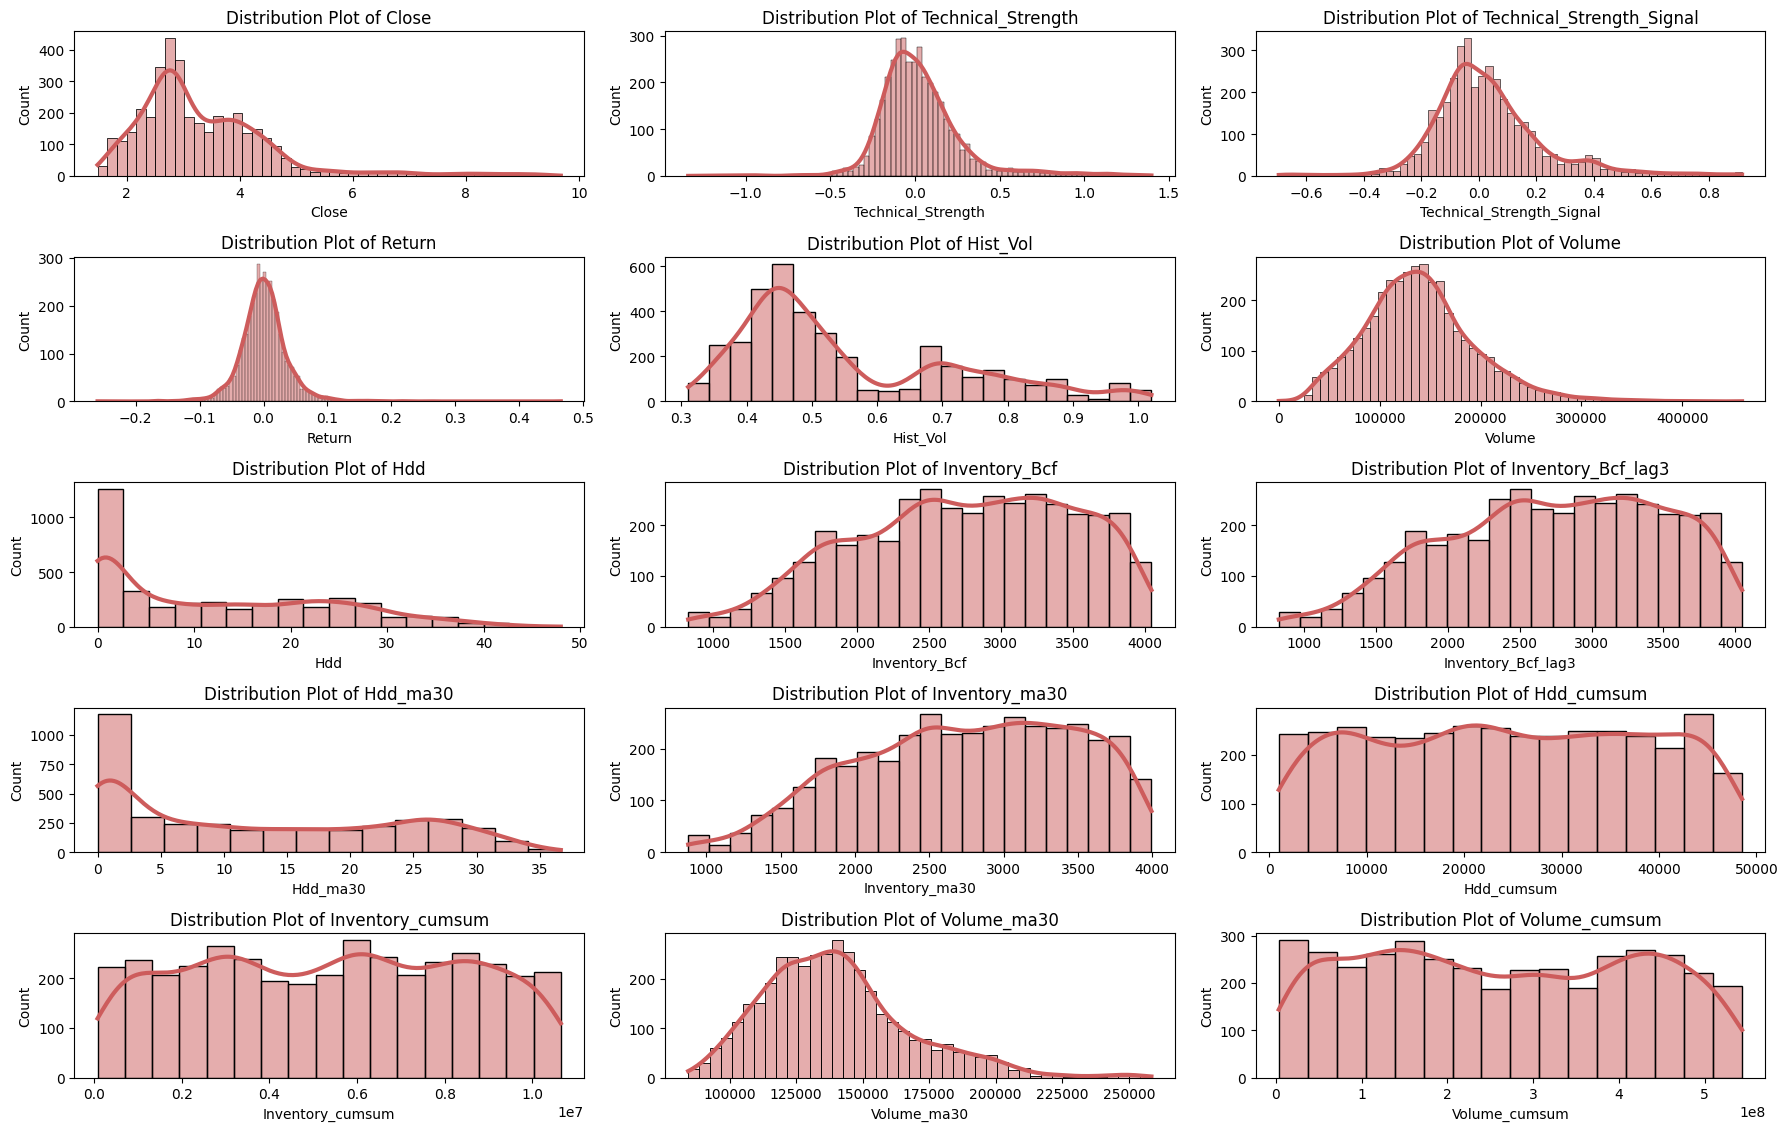

In [37]:
columns_to_plot = [col for col in result.columns if col != 'Date']
plt.figure(figsize=(18,20))
for i,col in enumerate(columns_to_plot,1):
    plt.subplot(9,3,i)
    sns.histplot(result[col],kde=True, color="indianred",line_kws={"linewidth": 3})
    plt.title(f"Distribution Plot of {col}")
    plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


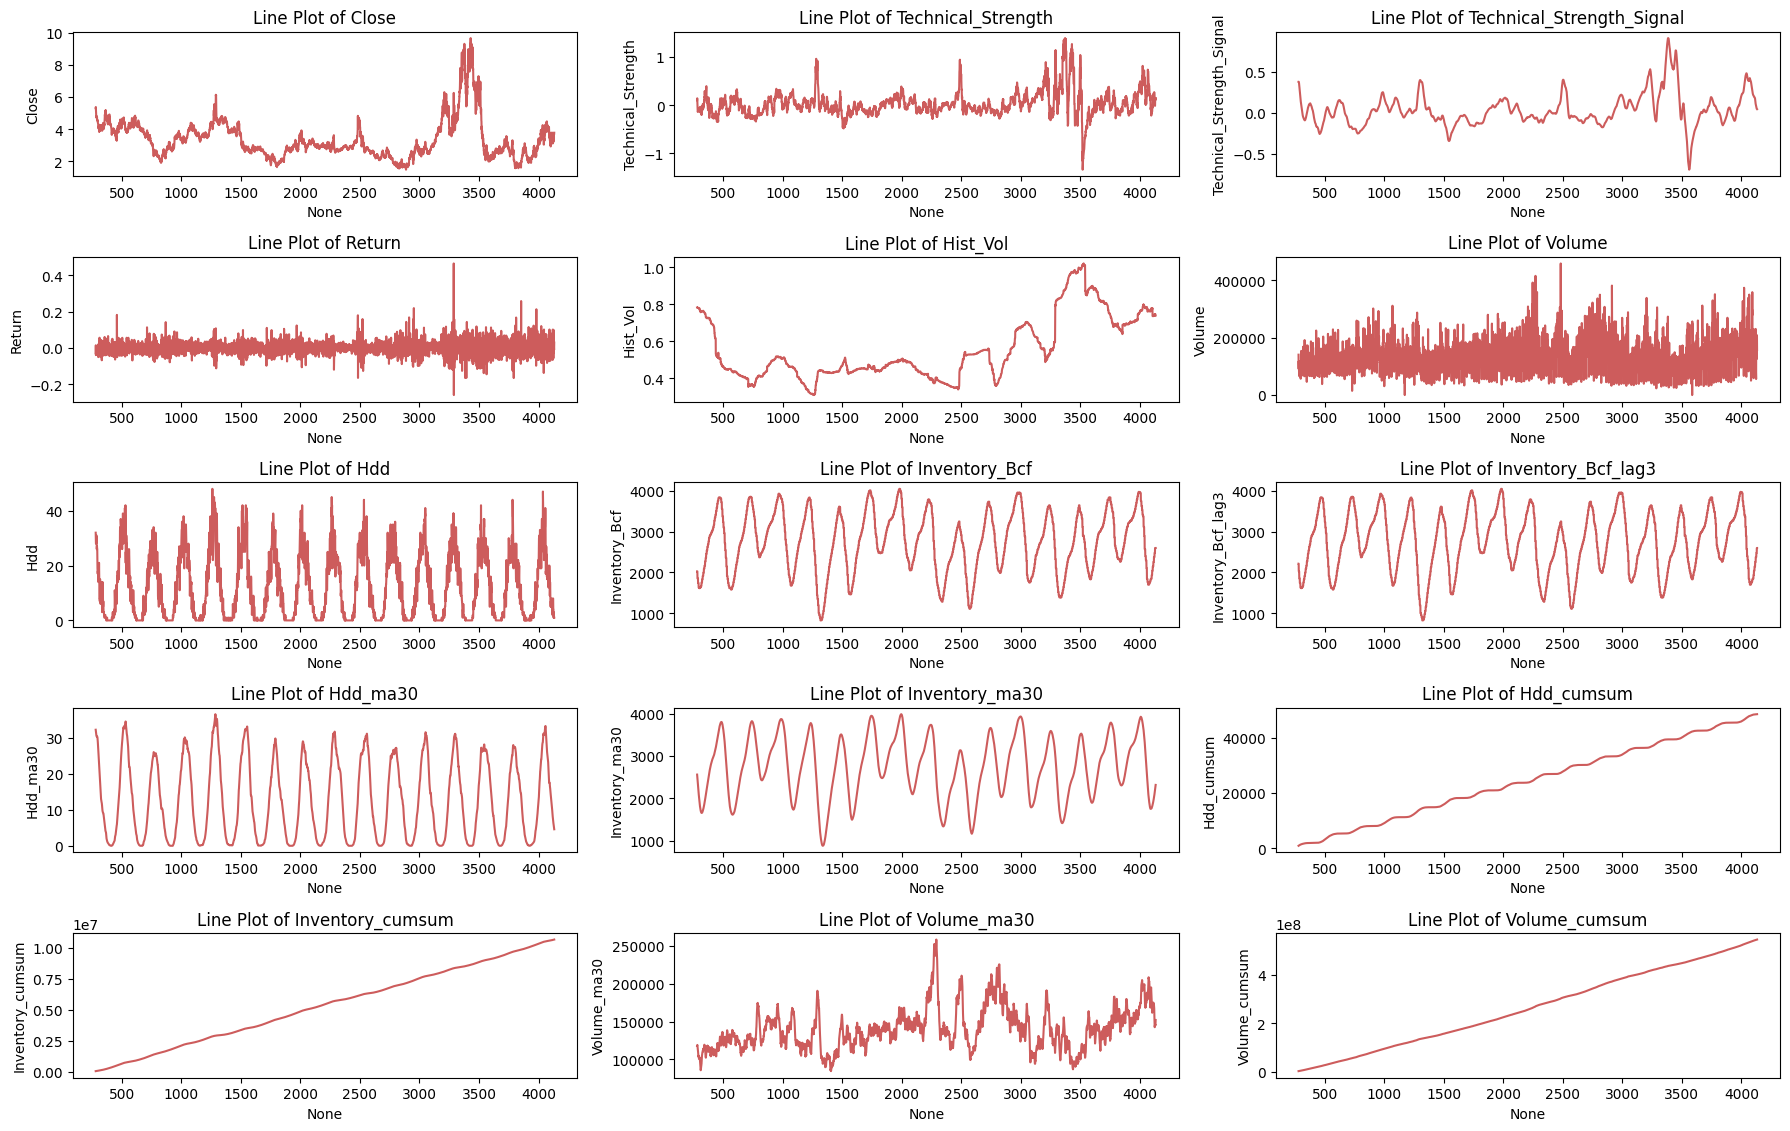

In [38]:
columns_to_plot = [col for col in result.columns if col != 'Date']
plt.figure(figsize=(18,20))
for i,col in enumerate(columns_to_plot,1):
    plt.subplot(9,3,i)
    sns.lineplot(x=result.index, y=result[col], color="indianred")
    plt.title(f"Line Plot of {col}")
    plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


In [39]:
scaled_train

array([[ 2.65038035,  0.65422485,  2.90040162, ..., -1.72854545,
        -0.74836431, -1.62979445],
       [ 2.74913835,  0.82698518,  2.90040162, ..., -1.72766033,
        -0.73371154, -1.62901699],
       [ 2.47755387,  0.36629096,  2.90040162, ..., -1.72677522,
        -0.7111095 , -1.62800654],
       ...,
       [ 1.20604323,  1.92113401,  1.91723994, ...,  1.71514884,
        -0.72313228,  1.79227194],
       [ 1.20604323,  1.74837368,  1.91723994, ...,  1.71636161,
        -0.59998602,  1.7935775 ],
       [ 1.10728524,  1.8059604 ,  1.99286769, ...,  1.71757438,
        -0.43272258,  1.7951119 ]])

In [40]:
# Sequence generation
def create_sequences(data, target, time_step):
    X, y = [], []
    for i in range(time_step, len(data)):
        X.append(data[i - time_step:i])
        y.append(target[i])
    return np.array(X), np.array(y)

TIME_STEP = 60
X_train_seq, y_train_seq = create_sequences(scaled_train, scaled_target_train, TIME_STEP)
X_test_seq, y_test_seq = create_sequences(scaled_test, scaled_target_test, TIME_STEP)


In [41]:
# Set all seeds for reproducibility
def set_seed(seed=42):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'
    os.environ['OMP_NUM_THREADS'] = '1'
    os.environ['TF_NUM_INTRAOP_THREADS'] = '1'
    os.environ['TF_NUM_INTEROP_THREADS'] = '1'

set_seed(42)

In [42]:
# Define LSTM Model for Optuna
def objective(trial):

    # Re-seed inside trial
    set_seed(42)
    
    # Hyperparameters
    layers = trial.suggest_int('layers', 1, 3)
    units = trial.suggest_categorical('units', [32, 64, 128])
    dropout = trial.suggest_float('dropout', 0.1, 0.5)
    learning_rate = trial.suggest_float('learning_rate', 1e-4, 1e-2, log=True)
    batch_size = trial.suggest_categorical('batch_size', [32, 64, 128])
    
    # Build model
    model = Sequential()
    for i in range(layers):
        return_seq = i < layers - 1
        if i == 0:
            model.add(LSTM(units, return_sequences=return_seq, input_shape=(X_train_seq.shape[1], X_train_seq.shape[2])))
        else:
            model.add(LSTM(units, return_sequences=return_seq))
        model.add(Dropout(dropout))
    model.add(Dense(1))
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                  loss='mean_squared_error')

    # Train
    history = model.fit(
        X_train_seq, y_train_seq,
        validation_data=(X_test_seq, y_test_seq),
        epochs=100,
        batch_size=batch_size,
        callbacks=[
            EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
            TFKerasPruningCallback(trial, "val_loss")
        ],
        verbose=0
    )

    # Return final validation loss
    val_loss = min(history.history['val_loss'])
    return val_loss

In [43]:
# Run Optuna
sampler = optuna.samplers.TPESampler(seed=42)
study = optuna.create_study(direction='minimize', sampler=sampler)
study.optimize(objective, n_trials=60)

# Best Trial Info
print(f"Best Trial:\n  Value: {study.best_trial.value}\n  Params: {study.best_trial.params}")

[I 2025-06-08 11:30:48,203] A new study created in memory with name: no-name-704a7333-1c44-4669-ab7b-3663fb5096e0


2025-06-08 11:30:48.396965: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)
2025-06-08 11:30:49.566889: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}
2025-06-08 11:30:56.991813: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_un

Best Trial:
  Value: 0.43192219734191895
  Params: {'layers': 1, 'units': 128, 'dropout': 0.4254426654338886, 'learning_rate': 0.0023667112722830274, 'batch_size': 32}


In [44]:
best_params = study.best_trial.params

final_model = Sequential()
for i in range(best_params['layers']):
    return_seq = i < best_params['layers'] - 1
    if i == 0:
        final_model.add(LSTM(best_params['units'], return_sequences=return_seq, input_shape=(X_train_seq.shape[1], X_train_seq.shape[2])))
    else:
        final_model.add(LSTM(best_params['units'], return_sequences=return_seq))
    final_model.add(Dropout(best_params['dropout']))
final_model.add(Dense(1))
final_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=best_params['learning_rate']),
                    loss='mean_squared_error')

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=25, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=10, min_lr=1e-6)

In [45]:
final_model.summary()

Model: "sequential_60"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_81 (LSTM)                  │ (None, 128)            │        72,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_81 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_60 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 72,321 (282.50 KB)

 Trainable params: 72,321 (282.50 KB)

 Non-trainable params: 0 (0.00 B)

In [46]:
best_params

{'layers': 1,
 'units': 128,
 'dropout': 0.4254426654338886,
 'learning_rate': 0.0023667112722830274,
 'batch_size': 32}

In [48]:
# Train
set_seed(42)
history = final_model.fit(
    X_train_seq, y_train_seq,
    validation_data=(X_test_seq, y_test_seq),
    epochs=300,
    batch_size=best_params['batch_size'],
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

Epoch 1/300


2025-06-08 13:16:06.401301: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


88/89 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - loss: 0.0349

2025-06-08 13:16:13.270348: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


89/89 ━━━━━━━━━━━━━━━━━━━━ 8s 81ms/step - loss: 0.0349 - val_loss: 0.8866 - learning_rate: 0.0024
Epoch 2/300
89/89 ━━━━━━━━━━━━━━━━━━━━ 7s 82ms/step - loss: 0.0335 - val_loss: 0.6992 - learning_rate: 0.0024
Epoch 3/300
89/89 ━━━━━━━━━━━━━━━━━━━━ 7s 83ms/step - loss: 0.0310 - val_loss: 0.8845 - learning_rate: 0.0024
Epoch 4/300
89/89 ━━━━━━━━━━━━━━━━━━━━ 7s 84ms/step - loss: 0.0303 - val_loss: 0.7011 - learning_rate: 0.0024
Epoch 5/300
89/89 ━━━━━━━━━━━━━━━━━━━━ 7s 81ms/step - loss: 0.0290 - val_loss: 0.7741 - learning_rate: 0.0024
Epoch 6/300
89/89 ━━━━━━━━━━━━━━━━━━━━ 7s 82ms/step - loss: 0.0285 - val_loss: 0.8107 - learning_rate: 0.0024
Epoch 7/300
89/89 ━━━━━━━━━━━━━━━━━━━━ 7s 80ms/step - loss: 0.0278 - val_loss: 0.7133 - learning_rate: 0.0024
Epoch 8/300
89/89 ━━━━━━━━━━━━━━━━━━━━ 7s 81ms/step - loss: 0.0270 - val_loss: 0.6612 - learning_rate: 0.0024
Epoch 9/300
89/89 ━━━━━━━━━━━━━━━━━━━━ 7s 80ms/step - loss: 0.0309 - val_loss: 0.5975 - learning_rate: 0.0024
Epoch 10/300
89/89 ━━━

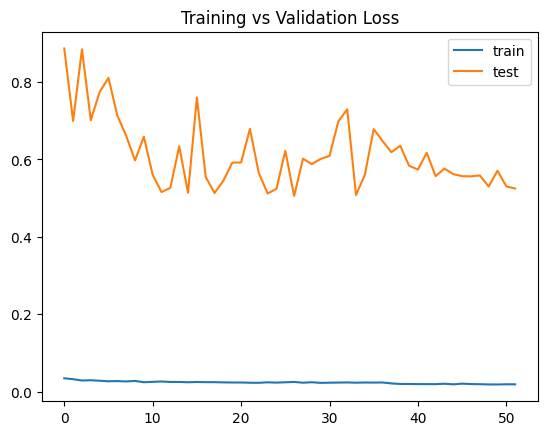

In [49]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.title("Training vs Validation Loss")
plt.legend()
plt.show()


In [50]:
# Predict & Inverse transform
y_pred = final_model.predict(X_test_seq)
predicted_close = close_scaler.inverse_transform(y_pred)
actual_close = close_scaler.inverse_transform(y_test_seq)

2025-06-08 13:22:32.392717: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step


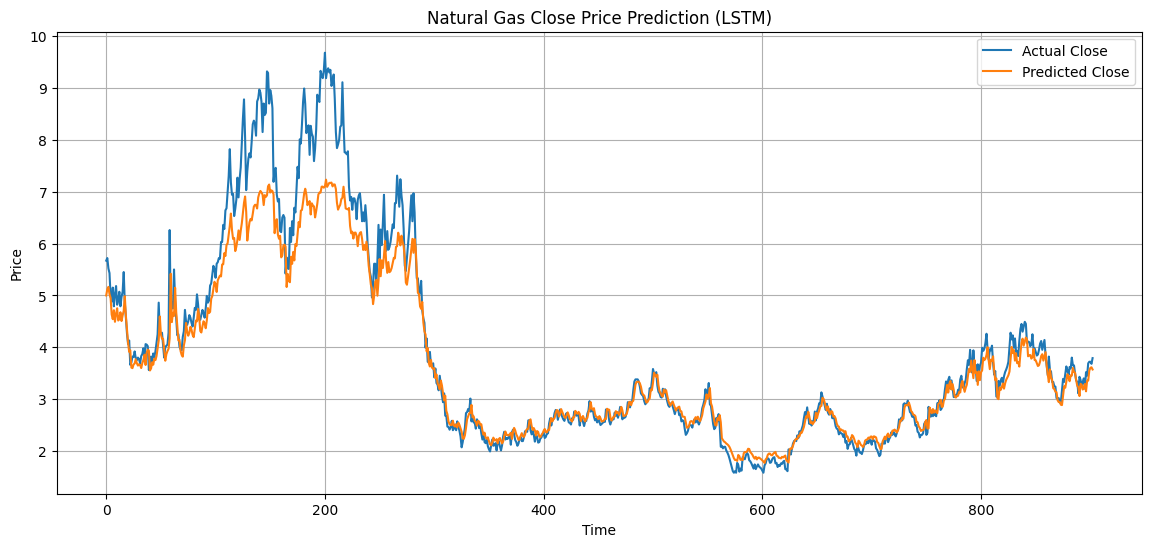

In [51]:
# Plot Actual vs Predicted
plt.figure(figsize=(14,6))
plt.plot(actual_close, label='Actual Close')
plt.plot(predicted_close, label='Predicted Close')
plt.title('Natural Gas Close Price Prediction (LSTM)')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

In [52]:
# Evaluation
rmse = np.sqrt(mean_squared_error(actual_close, predicted_close))
mae = mean_absolute_error(actual_close, predicted_close)

print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")

RMSE: 0.5761
MAE: 0.3278


In [53]:
# Future period 30 day volume simulation using Facebook Prophet
volume_df = data[['Date', 'Volume']].rename(columns={'Date': 'ds', 'Volume': 'y'})

model_vol = Prophet(
    seasonality_mode='multiplicative',
    daily_seasonality=True,
    yearly_seasonality=True,
    weekly_seasonality=True,
    changepoint_range=0.95,
    changepoint_prior_scale=0.2  # Increased flexibility
)
# Add custom seasonalities
model_vol.add_seasonality(name='monthly', period=30.5, fourier_order=5)
model_vol.fit(volume_df)

future_vol = model_vol.make_future_dataframe(periods=30)
forecast_vol = model_vol.predict(future_vol)

future_volume = forecast_vol['yhat'].iloc[-30:].values



DEBUG:cmdstanpy:input tempfile: /tmp/tmpw6um4r_0/htneep_1.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpw6um4r_0/n1pt4nuk.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/home/santoshkumarguntupalli/miniconda3/envs/myenv/lib/python3.11/site-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=88574', 'data', 'file=/tmp/tmpw6um4r_0/htneep_1.json', 'init=/tmp/tmpw6um4r_0/n1pt4nuk.json', 'output', 'file=/tmp/tmpw6um4r_0/prophet_model0rvysm8b/prophet_model-20250608132236.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:22:36 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:22:43 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [54]:
result=result.reset_index()

In [55]:
# Future period 30 day technical strength simulation using Facebook Prophet
ts_df = result[['Date', 'Technical_Strength']].dropna().rename(columns={'Date': 'ds', 'Technical_Strength': 'y'})

model_ts = Prophet(seasonality_mode='multiplicative',
    daily_seasonality=True,
    yearly_seasonality=True,
    weekly_seasonality=True,
    changepoint_range=0.95,
    changepoint_prior_scale=0.2  # Increased flexibility
)
# Add custom seasonalities
model_ts.add_seasonality(name='monthly', period=30.5, fourier_order=5)
model_ts.fit(ts_df)

future_ts = model_ts.make_future_dataframe(periods=30)
forecast_ts = model_ts.predict(future_ts)

future_strength = forecast_ts['yhat'].iloc[-30:].values


DEBUG:cmdstanpy:input tempfile: /tmp/tmpw6um4r_0/4mm99rn6.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpw6um4r_0/flg4i4r_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/home/santoshkumarguntupalli/miniconda3/envs/myenv/lib/python3.11/site-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=27140', 'data', 'file=/tmp/tmpw6um4r_0/4mm99rn6.json', 'init=/tmp/tmpw6um4r_0/flg4i4r_.json', 'output', 'file=/tmp/tmpw6um4r_0/prophet_modelmwov2cw4/prophet_model-20250608132245.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:22:45 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:22:58 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [56]:
# Future period 30 day heating degree days using Facebook Prophet
hdd_df = result[['Date', 'Hdd']].dropna().rename(columns={'Date': 'ds', 'Hdd': 'y'})

model_hdd = Prophet(
    seasonality_mode='multiplicative',
    daily_seasonality=True,
    yearly_seasonality=True,
    weekly_seasonality=True,
    changepoint_range=0.95,
    changepoint_prior_scale=0.2  # Increased flexibility
)
# Add custom seasonalities
model_hdd.add_seasonality(name='monthly', period=30.5, fourier_order=5)
model_hdd.fit(hdd_df)

future_hdd = model_hdd.make_future_dataframe(periods=30)
forecast_hdd = model_hdd.predict(future_hdd)

future_hdd = forecast_hdd['yhat'].iloc[-30:].values


DEBUG:cmdstanpy:input tempfile: /tmp/tmpw6um4r_0/wx4w7b0a.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpw6um4r_0/rqsj7_7h.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/home/santoshkumarguntupalli/miniconda3/envs/myenv/lib/python3.11/site-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=91556', 'data', 'file=/tmp/tmpw6um4r_0/wx4w7b0a.json', 'init=/tmp/tmpw6um4r_0/rqsj7_7h.json', 'output', 'file=/tmp/tmpw6um4r_0/prophet_modely9unq1dd/prophet_model-20250608132259.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:22:59 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:23:05 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [57]:
# Future period 30 day heating degree days using Facebook Prophet
bcf_df = result[['Date', 'Inventory_Bcf']].dropna().rename(columns={'Date': 'ds', 'Inventory_Bcf': 'y'})

model_bcf = Prophet(
    seasonality_mode='multiplicative',
    daily_seasonality=True,
    yearly_seasonality=True,
    weekly_seasonality=True,
    changepoint_range=0.95,
    changepoint_prior_scale=0.2  # Increased flexibility
)
# Add custom seasonalities
model_bcf.add_seasonality(name='monthly', period=30.5, fourier_order=5)
model_bcf.fit(bcf_df)

future_bcf = model_bcf.make_future_dataframe(periods=30)
forecast_bcf = model_bcf.predict(future_bcf)

future_bcf = forecast_bcf['yhat'].iloc[-30:].values


DEBUG:cmdstanpy:input tempfile: /tmp/tmpw6um4r_0/zwbcpsiq.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpw6um4r_0/oxizacf7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/home/santoshkumarguntupalli/miniconda3/envs/myenv/lib/python3.11/site-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=79941', 'data', 'file=/tmp/tmpw6um4r_0/zwbcpsiq.json', 'init=/tmp/tmpw6um4r_0/oxizacf7.json', 'output', 'file=/tmp/tmpw6um4r_0/prophet_model5nab0awu/prophet_model-20250608132306.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:23:06 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:23:13 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [58]:


# Take only returns with no NaN
returns = result['Return'].dropna() * 100  # percentage scale

# How many days to forecast ahead (adjustable)
forecast_horizon = 30

# Initialize list for rolling predictions
rolling_predictions = []

# Rolling forecast (similar to your reference)
for i in range(forecast_horizon):
    train_data = returns[:-(forecast_horizon - i)]
    
    garch_model = arch_model(train_data, dist="ged", vol='GARCH', p=1, q=1)
    model_fit = garch_model.fit(disp='off')
    
    # Forecast 1-day ahead volatility (variance), take sqrt and scale back
    forecast = model_fit.forecast(horizon=1, reindex=False)
    next_vol = np.sqrt(forecast.variance.values[-1][0])*np.sqrt(252)
    rolling_predictions.append(next_vol/100)

# Convert to pandas Series
last_date = result['Date'].iloc[-1]
future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=forecast_horizon)

future_volatility_series = pd.Series(rolling_predictions, index=future_dates, name='Predicted_Hist_Vol')

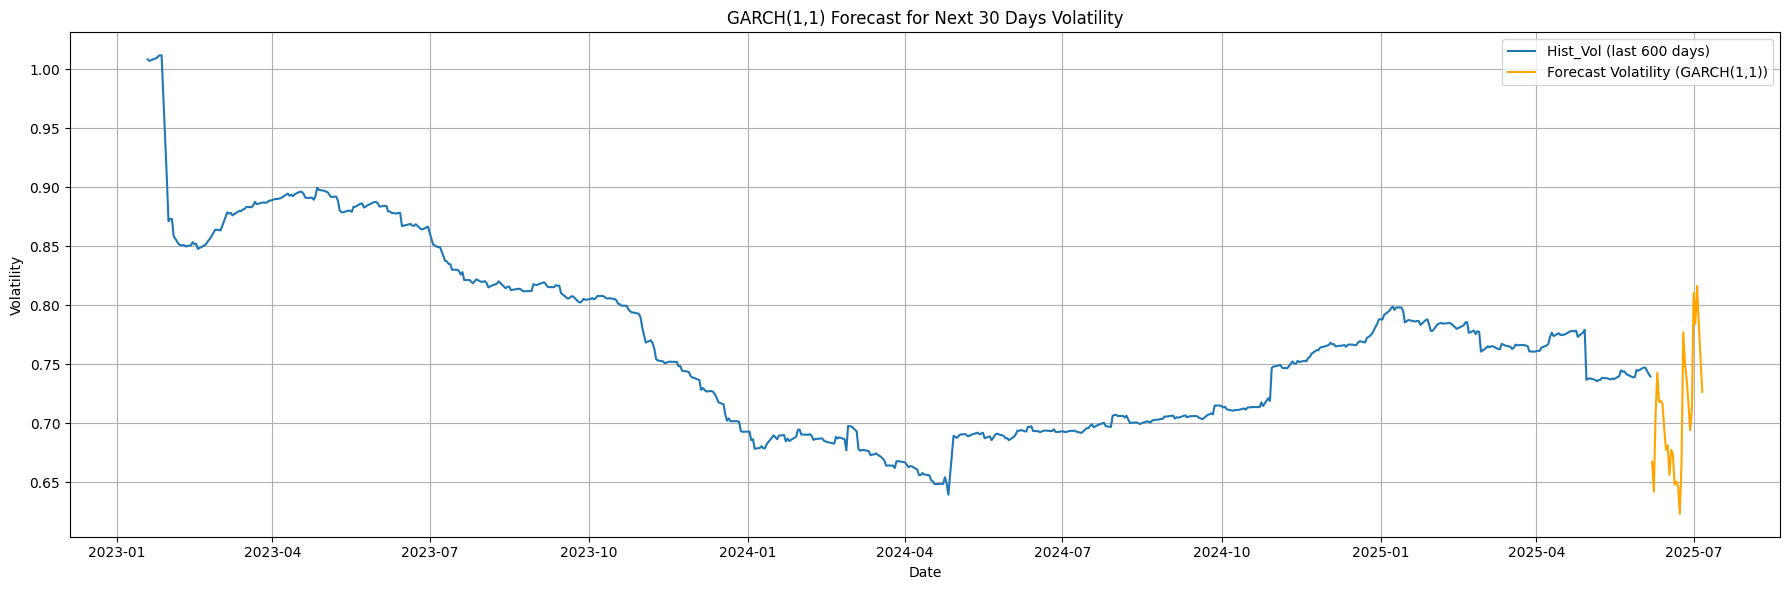

In [59]:
# Plot
plt.figure(figsize=(18,6))
plt.plot(result['Date'].iloc[-600:], result['Hist_Vol'].iloc[-600:], label='Hist_Vol (last 600 days)')
plt.plot(future_volatility_series, label='Forecast Volatility (GARCH(1,1))', linestyle='-', color='orange')
plt.title("GARCH(1,1) Forecast for Next 30 Days Volatility")
plt.xlabel("Date")
plt.ylabel("Volatility")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [60]:
# Combine last known 60 rows with future simulated features
last_known = df_model.iloc[-60:].copy()


In [61]:
# Future Gunsan Strength Signal
ts_full_for_signal = pd.concat([
    result['Technical_Strength'].iloc[-252:],  # Last known
    pd.Series(future_strength, index=future_dates)  # Simulated
])
future_signal = ts_full_for_signal.rolling(252).mean().loc[future_dates]

# Future Inventory Feature Engineering
inv_bcf_for_signal = pd.concat([
    result['Inventory_Bcf'].iloc[-40:],  # Last known
    pd.Series(future_bcf, index=future_dates)  # Simulated
])
last_inventory_cumsum = df_model['Inventory_cumsum'].iloc[-1]
future_inventory_lag3 = inv_bcf_for_signal.shift(3).loc[future_dates]
future_inventory_cumsum = inv_bcf_for_signal.cumsum().loc[future_dates]+last_inventory_cumsum
future_inventory_ma30 = inv_bcf_for_signal.rolling(window=30).mean().loc[future_dates]

# Future HDD Feature Engineering
hdd_for_signal = pd.concat([
    result['Hdd'].iloc[-40:],  # Last known
    pd.Series(future_hdd, index=future_dates)  # Simulated
])
last_hdd_cumsum = df_model['Hdd_cumsum'].iloc[-1]
future_hdd_cumsum = hdd_for_signal.cumsum().loc[future_dates]+last_hdd_cumsum
future_hdd_ma30 = hdd_for_signal.rolling(window=30).mean().loc[future_dates]

# Future Volume Feature Engineering
volume_for_signal = pd.concat([
    result['Volume'].iloc[-40:],  # Last known
    pd.Series(future_volume, index=future_dates)  # Simulated
])
last_volume_cumsum = df_model['Volume_cumsum'].iloc[-1]
future_volume_cumsum = volume_for_signal.cumsum().loc[future_dates]+last_volume_cumsum
future_volume_ma30 = volume_for_signal.rolling(window=30).mean().loc[future_dates]





In [62]:
# Add the simulated values to form a future frame
future_data = pd.DataFrame({
    'Close': 0,  # dummy
    'Technical_Strength': future_strength,
    'Technical_Strength_Signal': future_signal,
    'Hist_Vol': future_volatility_series,
    'Inventory_Bcf': future_bcf,
    'Inventory_Bcf_lag3': future_inventory_lag3,
    'Hdd_ma30': future_hdd_ma30,
    'Inventory_ma30': future_inventory_ma30,
    'Hdd_cumsum': future_hdd_cumsum,
    'Inventory_cumsum': future_inventory_cumsum,
    'Volume_ma30': future_volume_ma30,
    'Volume_cumsum': future_volume_cumsum
}, index=future_dates)

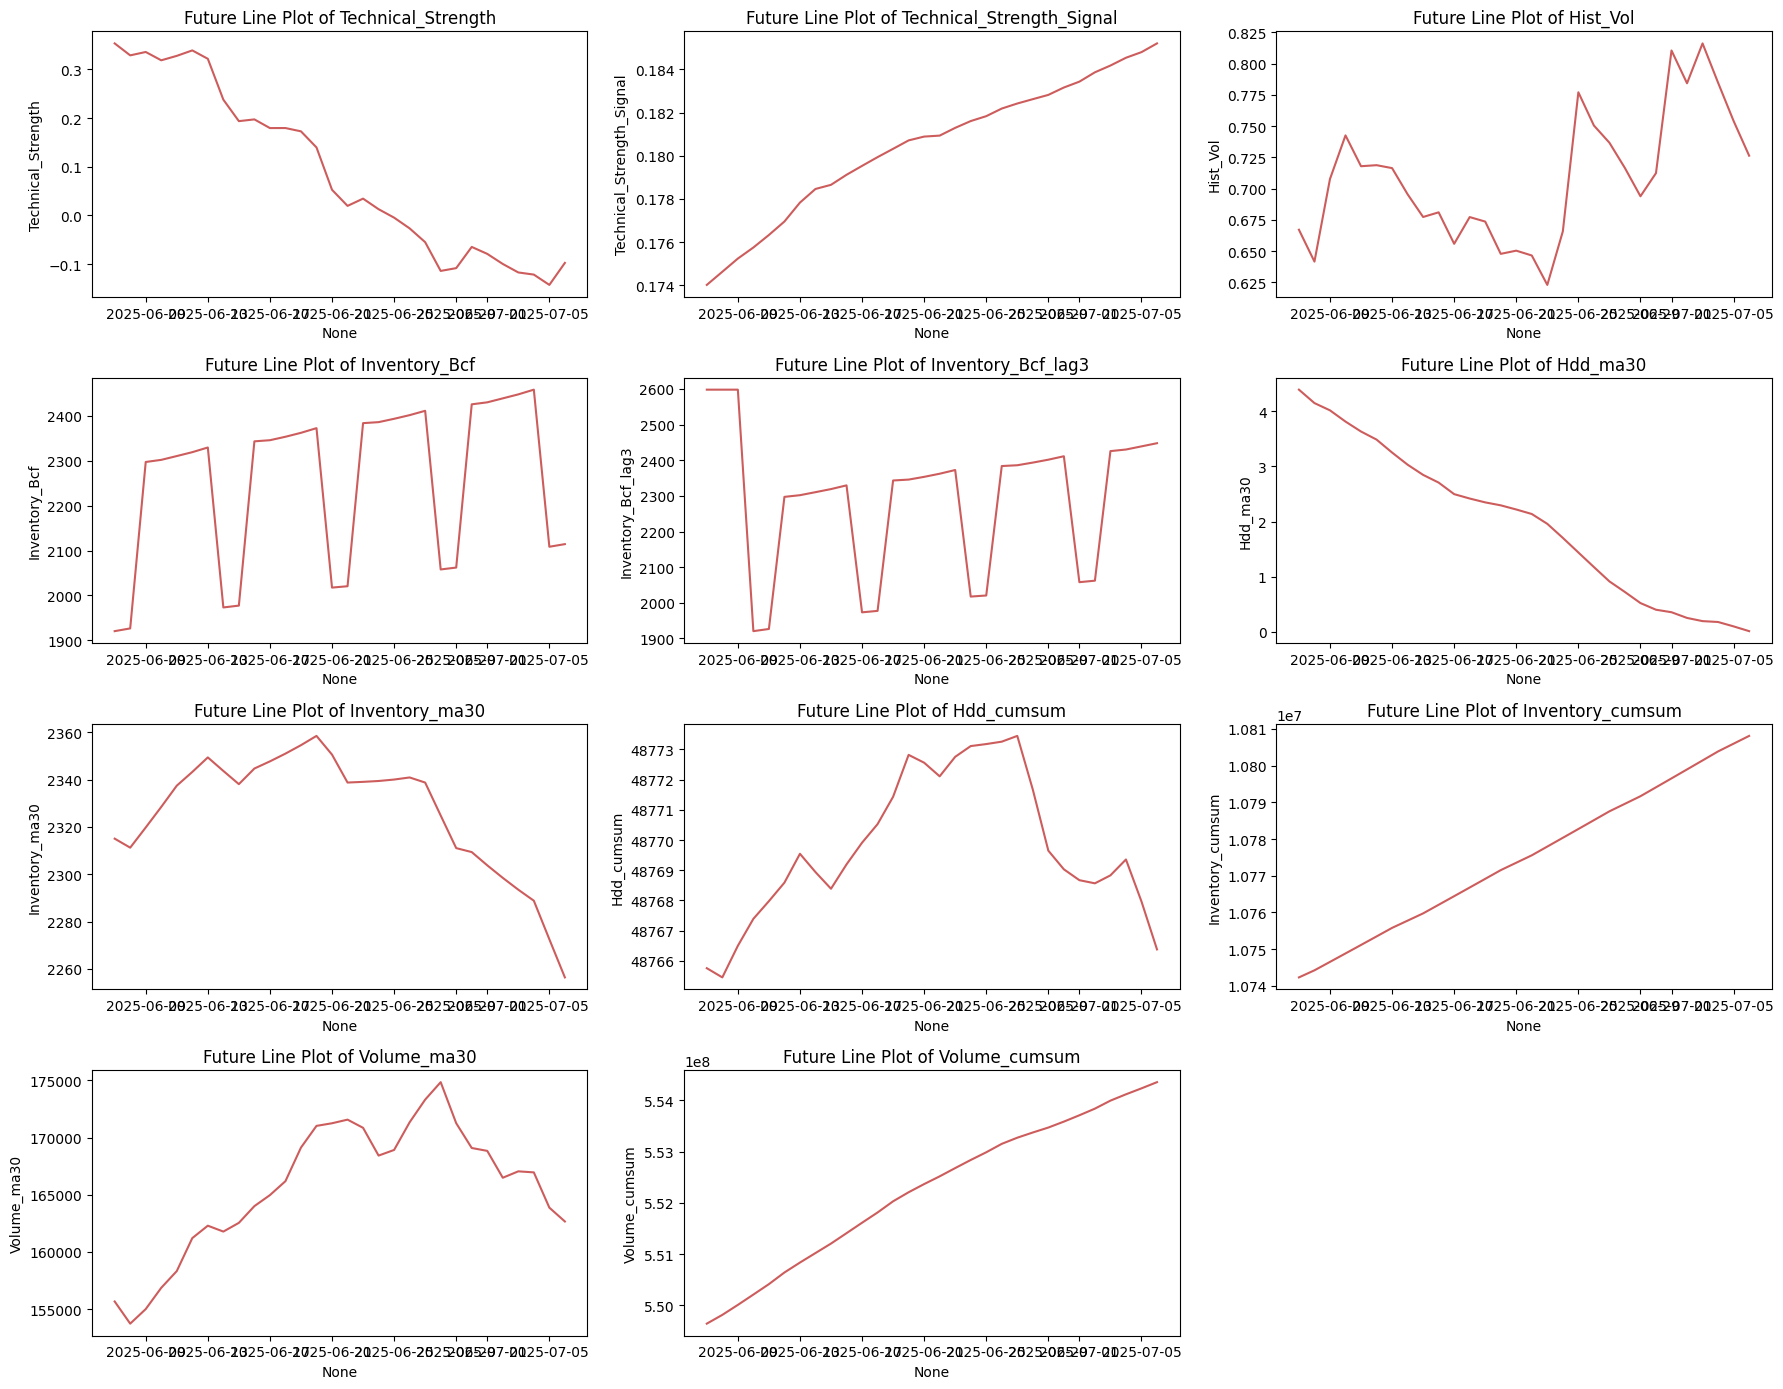

In [63]:
columns_to_plot = [col for col in future_data.columns if col != 'Close']
plt.figure(figsize=(18, 14))
for i, col in enumerate(columns_to_plot, 1):
    plt.subplot(4, 3, i)
    sns.lineplot(x=future_data.index, y=future_data[col], color="indianred")
    plt.title(f"Future Line Plot of {col}")
    plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


In [64]:
# Reorder columns to match training set
future_data = future_data[df_model.columns]
future_data = future_data.round(2).astype(feature_dtypes)

In [65]:
last_known.tail()

,Close,Technical_Strength,Technical_Strength_Signal,Hist_Vol,Inventory_Bcf,Inventory_Bcf_lag3,Hdd_ma30,Inventory_ma30,Hdd_cumsum,Inventory_cumsum,Volume_ma30,Volume_cumsum
4128,3.69,0.13,0.05,0.75,2598.0,2476.0,5.33,2230.530029,48519.0,10641640.0,146463.171875,542777620.0
4129,3.72,0.12,0.05,0.75,2598.0,2476.0,5.10,2252.669922,48521.0,10644238.0,145272.968750,542917030.0
4130,3.72,0.15,0.05,0.74,2598.0,2598.0,4.90,2274.800049,48522.0,10646836.0,145010.203125,543043123.0
4131,3.68,0.11,0.05,0.74,2598.0,2598.0,4.73,2296.929932,48523.0,10649434.0,149097.671875,543251887.0
4132,3.79,0.15,0.05,0.74,2598.0,2598.0,4.60,2319.070068,48524.0,10652032.0,152105.734375,543409113.0


In [66]:
future_data.head()

,Close,Technical_Strength,Technical_Strength_Signal,Hist_Vol,Inventory_Bcf,Inventory_Bcf_lag3,Hdd_ma30,Inventory_ma30,Hdd_cumsum,Inventory_cumsum,Volume_ma30,Volume_cumsum
2025-06-07,0.0,0.35,0.17,0.67,1920.579956,2598.000000,4.39,2315.050049,48765.761719,10742320.58,155668.046875,5.496423e+08
2025-06-08,0.0,0.33,0.17,0.64,1926.689941,2598.000000,4.15,2311.239990,48765.449219,10744247.27,153729.031250,5.498136e+08
2025-06-09,0.0,0.34,0.18,0.71,2297.239990,2598.000000,4.02,2319.780029,48766.500000,10746544.51,155002.484375,5.500084e+08
2025-06-10,0.0,0.32,0.18,0.74,2301.979980,1920.579956,3.81,2328.479980,48767.390625,10748846.49,156862.453125,5.502102e+08
2025-06-11,0.0,0.33,0.18,0.72,2310.439941,1926.689941,3.63,2337.459961,48767.980469,10751156.93,158325.109375,5.504137e+08


In [67]:
# Combine and scale
future_full = pd.concat([last_known, future_data])
scaled_future = feature_scaler.transform(future_full)

In [68]:
# Rolling prediction
future_predictions = []
current_input = scaled_future[:60].copy()

for i in range(30):
    input_seq = current_input[-60:].reshape(1, 60, scaled_future.shape[1])
    next_scaled_close = final_model.predict(input_seq, verbose=0)[0][0]
    future_predictions.append(next_scaled_close)
    
    next_row = scaled_future[60 + i].copy()
    next_row[0] = next_scaled_close
    current_input = np.vstack([current_input, next_row])

2025-06-08 13:23:23.469998: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


In [69]:
# Inverse transform
future_close_prices = close_scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))

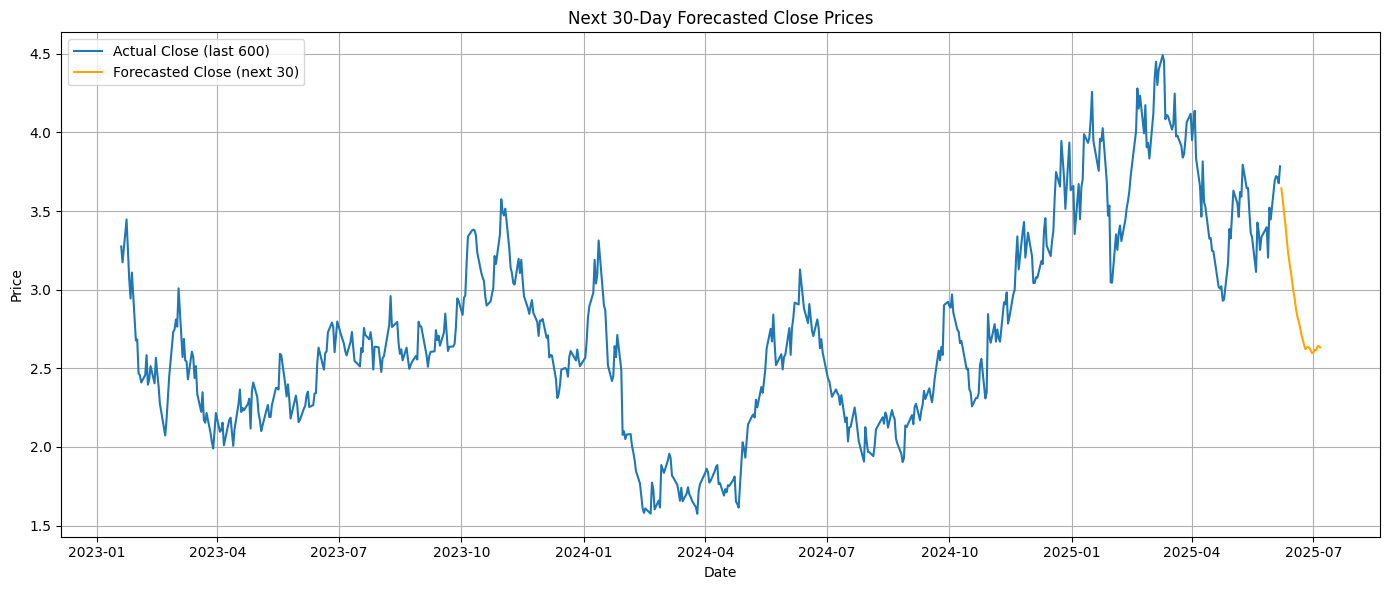

In [70]:
# Plot
plt.figure(figsize=(14,6))
plt.plot(result['Date'].iloc[-600:], result['Close'].iloc[-600:], label="Actual Close (last 600)")
plt.plot(future_dates, future_close_prices, label="Forecasted Close (next 30)", linestyle='-', color='orange')
plt.title("Next 30-Day Forecasted Close Prices")
plt.xlabel("Date")
plt.ylabel("Price")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()